# Exercise 11


- **Exercise 11.1**

In order to make practice with NN, explore how does the previous linear regression depend on the number of epochs, $N_{\mathrm{epochs}}$, the number of data points $N_{\mathrm{train}}$ and on the noise $\sigma$. Try to improve the previous result operating on these parameters.

In [1]:
# compose the NN model
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import itertools
from mpl_toolkits.mplot3d import Axes3D
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, LeakyReLU
from tensorflow.keras import backend as K
from tensorflow.keras.utils import get_custom_objects

model = tf.keras.Sequential()
model.add(Dense(1, input_shape=(1,)))

# compile the model choosing optimizer, loss and metrics objects
model.compile(optimizer='sgd', loss='mse', metrics=['mse'])

In [2]:
sigmas = [0.25, 0.5, 0.75, 1.0]
sample_size = [50, 100, 500, 1000]

m = 2
b = 1

In [3]:
%%capture
x_pred = np.random.uniform(-1, 1, 100)
val_size = 500
histories = []
epoch = []
pred = []
for s in sigmas:
    for ss in sample_size:
        np.random.seed(0)
        x_train = np.random.uniform(-1, 1, ss)
        x_valid = np.random.uniform(-1, 1, val_size)
        x_valid.sort()

        sigma = s # noise standard deviation
        y_train = np.random.normal(m * x_train + b, sigma) # actual measures from which we want to guess regression parameters
        y_valid = np.random.normal(m * x_valid + b, sigma)
        model = tf.keras.Sequential()
        model.add(Dense(1, input_shape=(1,)))

        # compile the model choosing optimizer, loss and metrics objects
        model.compile(optimizer='sgd', loss='mse', metrics=['mse'])
        
        history = model.fit(x=x_train, y=y_train, 
          batch_size=32, epochs=200,
          shuffle=True, # a good idea is to shuffle input before at each epoch
          validation_data=(x_valid, y_valid))
        histories.append(history)
        epoch.append(np.argmin(history.history['val_loss']))
        pred.append(model.predict(x_pred))

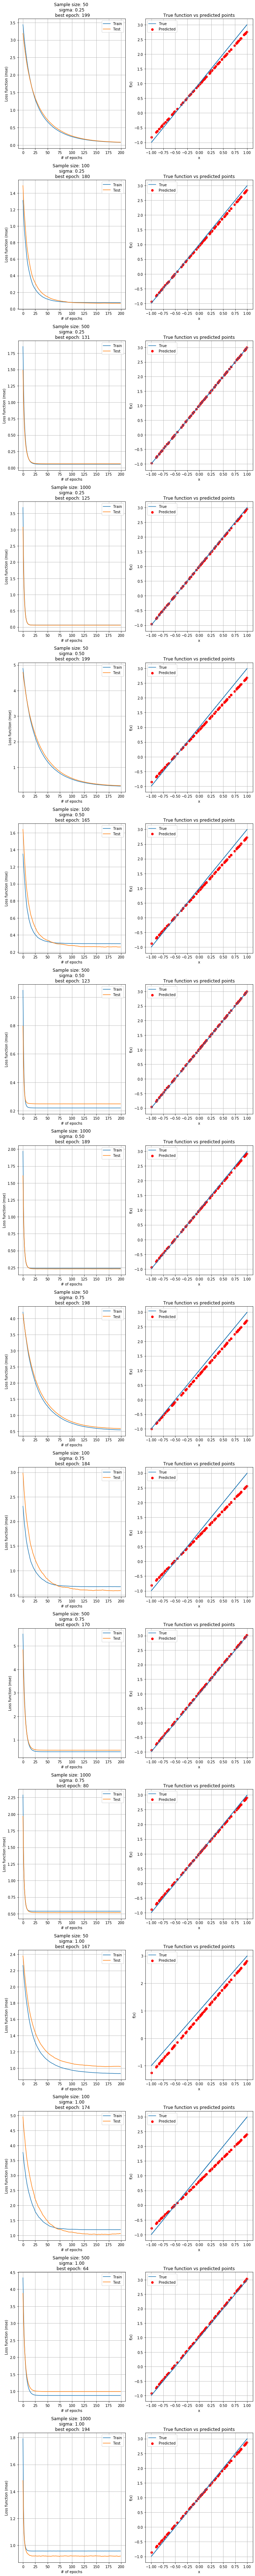

In [4]:
titles = list(itertools.product(sigmas, sample_size))

fig, ax = plt.subplots(16,2, figsize=(10, 100))
for j in range(len(sample_size)*len(sigmas)):
    ax[j,0].set_title('Sample size: {:.0f} \n sigma: {:.2f} \n best epoch: {:.0f}'.format(titles[j][1], titles[j][0], epoch[j]))
    ax[j,0].plot(histories[j].history['loss'], label='Train')
    ax[j,0].plot(histories[j].history['val_loss'], label='Test')
    ax[j,0].set_xlabel('# of epochs')
    ax[j,0].set_ylabel('Loss function (mse)')
    ax[j,0].grid(True)
    ax[j,0].legend()
    ax[j,1].set_title('True function vs predicted points')
    ax[j,1].plot(x_train, m*x_train+b, label='True')
    ax[j,1].scatter(x_pred, pred[j], color='r', label='Predicted')
    ax[j,1].set_xlabel('x')
    ax[j,1].set_ylabel('f(x)')
    ax[j,1].grid(True)
    ax[j,1].legend()
    fig.tight_layout()

The results showed that, as expected, the results improved increasing the size of the training sample at the expense of the time needed for training.
Also expected is the worsening of the predictions with high noise because that moves the points away from the target function making the regression problem more difficult.


- **Exercise 11.2**

Try to extend the model to obtain a reasonable fit of the following polynomial of order 3:

$$
f(x)=4-3x-2x^2+3x^3
$$
for $x \in [-1,1]$.

In order to make practice with NN, explore reasonable different choices for:

- the number of layers
- the number of neurons in each layer
- the activation function
- the optimizer
- the loss function
  
Make graphs comparing fits for different NNs.
Check your NN models by seeing how well your fits predict newly generated test data (including on data outside the range you fit. How well do your NN do on points in the range of $x$ where you trained the model? How about points outside the original training data set? 
Summarize what you have learned about the relationship between model complexity (number of parameters), goodness of fit on training data, and the ability to predict well.

Ideas behind hyperparameters selection:
- *optimizers*: faster convergence with adaptive learning rate -> Adadelta, Adam, RMSprop, Adamax
- *activation function*: we need to introduce non-linearity -> use 'tanh' or 'sigmoid' but both showed vanishing gradient problems -> resolve with 'exponential', 'elu', 'leakyReLU'
- *loss functions*: regression problem -> use 'mse' or 'mae'

Example of "Vanishing gradient" with *tanh* activation
<img src="grad_tanh.png">

In [5]:
def create_model_pol3(n_layers, neurons, opt, act, loss_func):
    assert n_layers==len(neurons)
    
    model = tf.keras.Sequential()
    model.add(Dense(neurons[0], input_shape=(1,)))
    model.add(LeakyReLU())
    for lay in range(n_layers-1):
        model.add(Dense(neurons[lay+1]))
        model.add(LeakyReLU())
    model.add(Dense(1, activation=act))
    model.compile(optimizer=opt, loss=loss_func, metrics=[loss_func])

    return model

def pol3(x):
    return 4+b*x+c*(x)**2+d*(x)**3

In [6]:
#parameters
a = 4
b = -3
c = -2
d = 3

In [7]:
%%capture
x_pred = np.random.uniform(-1,1, 100)
x_pred.sort()
sample_sz = 10000
hyper = [[3,[8,3,3], 'adam', 'tanh', 'mse'],
         [1,[5], 'adadelta', 'exponential', 'mse'],
         [1,[5], 'rmsprop', 'exponential', 'mse'],
         [1,[5], 'rmsprop', 'elu', 'mse'],
         [1,[5], 'adam', 'exponential', 'mse'],
         [1,[5], 'adam', 'elu', 'mse'],
         [3,[8,5,3], 'adamax', 'elu', 'mse'],
         [3,[8,5,3], 'adamax', 'exponential', 'mse'],
         [3,[8,5,3], 'adam', 'elu', 'mse'],
         [3,[8,5,3], 'adam', 'elu', 'mae'],
         [3,[8,5,3], 'rmsprop', 'exponential', 'mse'],
         [3,[8,5,3], 'rmsprop', 'exponential', 'mae']]
histories = []
pred = []
for i in range(len(hyper)):
    x_train = np.random.uniform(-1, 1, sample_sz)
    x_valid = np.random.uniform(-1, 1, 100)
    x_valid.sort()

    sigma = 0.1 # noise standard deviation, for the moment it is absent
    y_train = np.random.normal(pol3(x_train), sigma) # actual measures from which we want to guess regression parameters
    y_valid = np.random.normal(pol3(x_valid), sigma)
    model = create_model_pol3(hyper[i][0],hyper[i][1], hyper[i][2], hyper[i][3], hyper[i][4])
        
    history = model.fit(x=x_train, y=y_train, 
        batch_size=32, epochs=400,
        shuffle=True, # a good idea is to shuffle input before at each epoch
        validation_data=(x_valid, y_valid),
        callbacks=tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True))
    histories.append(history)
    pred.append(model.predict(x_pred))

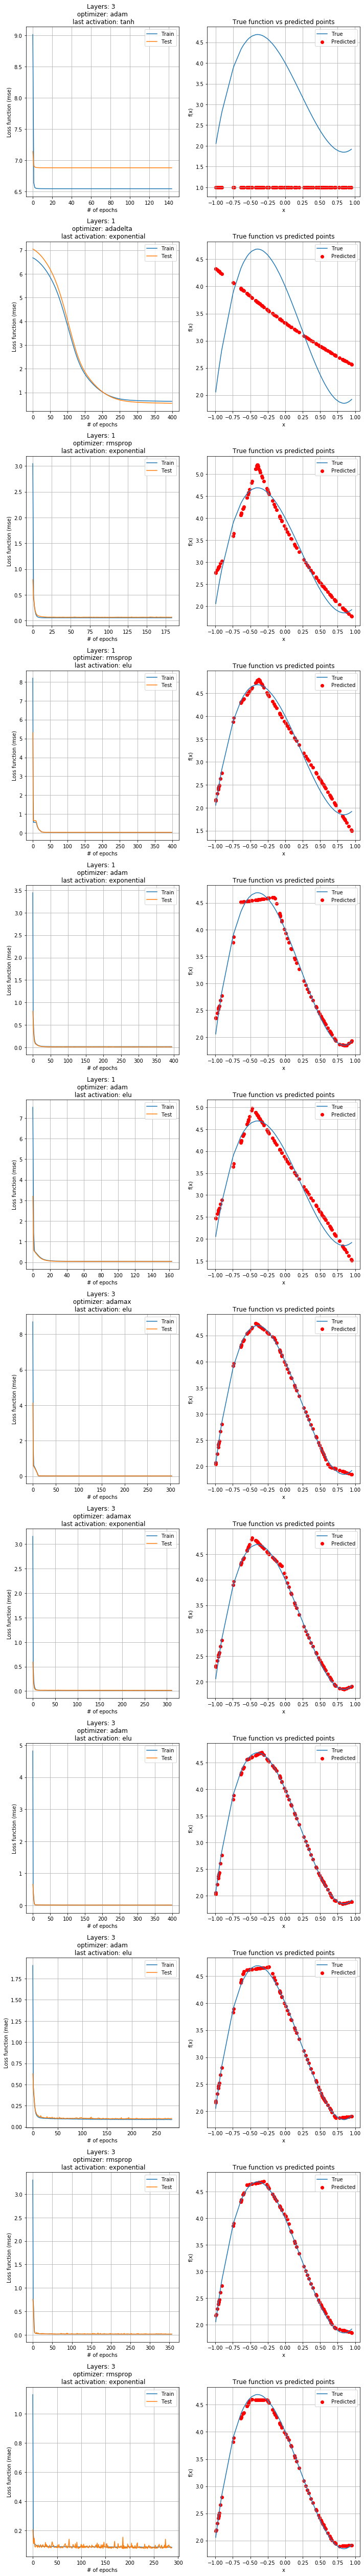

In [8]:
fig, ax = plt.subplots(12,2, figsize=(10, 70))
for j in range(len(hyper)):
    ax[j,0].set_title('Layers: {:.0f} \n optimizer: {} \n last activation: {}'.format(hyper[j][0], hyper[j][2], hyper[j][3]))
    ax[j,0].plot(histories[j].history['loss'], label='Train')
    ax[j,0].plot(histories[j].history['val_loss'], label='Test')
    ax[j,0].set_xlabel('# of epochs')
    ax[j,0].set_ylabel('Loss function ({})'.format(hyper[j][4]))
    ax[j,0].grid(True)
    ax[j,0].legend()
    ax[j,1].set_title('True function vs predicted points')
    ax[j,1].plot(x_pred, pol3(x_pred), label='True')
    ax[j,1].scatter(x_pred, pred[j], color='r', label='Predicted')
    ax[j,1].set_xlabel('x')
    ax[j,1].set_ylabel('f(x)')
    ax[j,1].grid(True)
    ax[j,1].legend()
    fig.tight_layout()

The first two plot show two bad training, the first case is the esult with vanishing gradient while in the second case Adadelta converge too much slowly in the number of epochs used.

Using only one layer the results were not good enough, indeed with all the hyperparameters used the predictions were not smooth enough.

With three layers, the best results were obtained with 'adam' optimizer and 'elu' as last activation function.

Regarding the loss function, all the training with 3 layers can be considered good because there is no overfitting on the training data.

The callback EarlyStopping() was used to prevent this problem.

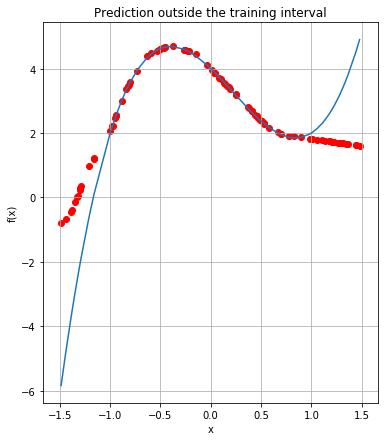

In [9]:
x_train = np.random.uniform(-1, 1, 10000)
x_valid = np.random.uniform(-1, 1, 100)
x_valid.sort()

sigma = 0.1 # noise standard deviation, for the moment it is absent
y_train = np.random.normal(pol3(x_train), sigma) # actual measures from which we want to guess regression parameters
y_valid = np.random.normal(pol3(x_valid), sigma)
model = create_model_pol3(3,[8,5,3], 'adam', 'elu', 'mse')
        
history = model.fit(x=x_train, y=y_train, 
    batch_size=32, epochs=400,
    shuffle=True, # a good idea is to shuffle input before at each epoch
    validation_data=(x_valid, y_valid),
    callbacks=tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True), verbose=False)

x_pred = np.random.uniform(-1.5, 1.5, 100)
x_pred.sort()
y_pred = model.predict(x_pred)

plt.figure(figsize=(6,7))
plt.plot(x_pred, pol3(x_pred), label='True')
plt.scatter(x_pred, y_pred, color='r', label='Predicted')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('Prediction outside the training interval')
plt.grid(True)

As expected the model is not able to reproduce data outside the trained range.
This happens because the NN find the best weights for the training sample, however it is not trained outside that range.

- **Exercise 11.3**

Try to extend the model to fit a simple trigonometric 2D function such as $f(x,y) = \sin(x^2+y^2)$ in the range $x \in [-3/2,3/2]$ and $y \in [-3/2,3/2]$.

Trying to train with the best set used in exercise 11.2:
- optimizer: Adam
- hidden layers: 3 with [8,3,3] neurons
- last activation: 'elu'

In [10]:
def sinxy(x,y):
    return np.sin(x**2+y**2)

def create_model_sinxy(n_layers, neurons, opt):
    assert n_layers==len(neurons)
    
    model = tf.keras.Sequential()
    model.add(Dense(neurons[0], input_shape=(2,)))
    model.add(LeakyReLU())
    for lay in range(n_layers-1):
        model.add(Dense(neurons[lay+1]))
        model.add(LeakyReLU())
    model.add(Dense(1, activation='elu'))
    model.compile(optimizer=opt, loss='mse', metrics=['mse'])

    return model

In [11]:
%%capture
x_train = np.random.uniform(-1.5, 1.5, 10000)
y_train = np.random.uniform(-1.5, 1.5, 10000)
x_valid, y_valid = [np.random.uniform(-1.5, 1.5, 1000), np.random.uniform(-1.5, 1.5, 1000)]
in_valid = np.array([x_valid,y_valid]).T
in_train = np.array([x_train,y_train]).T
sigma = 0.1 # noise standard deviation, for the moment it is absent
z_train = np.random.normal(sinxy(x_train, y_train), sigma) # actual measures from which we want to guess regression parameters
z_valid = np.random.normal(sinxy(x_valid, y_valid), sigma)
model = create_model_sinxy(3,[8,3,3], 'adam')
        
history = model.fit(x=in_train, y=z_train,
            batch_size=32, epochs=500,
            shuffle=True, # a good idea is to shuffle input before at each epoch
            validation_data=(in_valid,z_valid),
            callbacks=tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=100))

Text(0.5, 0.92, 'Predicted values')

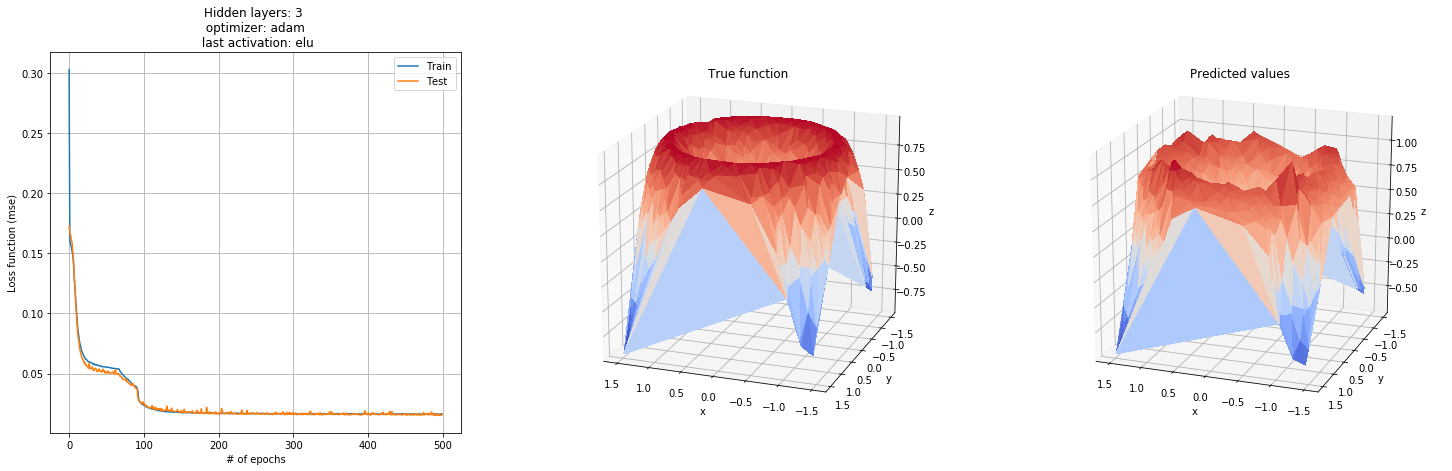

In [12]:
x_pred = np.random.uniform(-1.5, 1.5, 1000)
y_pred = np.random.uniform(-1.5, 1.5, 1000)
in_pred = np.array([x_pred,y_pred]).T
z_pred = model.predict(in_pred)

fig = plt.figure(figsize=(25,7))
ax = fig.add_subplot(131)
ax.plot(history.history['loss'], label='Train')
ax.plot(history.history['val_loss'], label='Test')
ax.set_xlabel('# of epochs')
ax.set_ylabel('Loss function (mse)')
ax.set_title('Hidden layers: 3 \n optimizer: adam \n last activation: elu')
ax.legend()
ax.grid(True)


ax = fig.add_subplot(132, projection='3d')
ax.view_init(20,110)
ax.plot_trisurf(x_pred, y_pred, sinxy(x_pred,y_pred), linewidth=0.1, antialiased=False, cmap=cm.coolwarm)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title('True function')

ax = fig.add_subplot(133, projection='3d')
ax.view_init(20, 110)
ax.plot_trisurf(x_pred, y_pred, z_pred.flatten(), linewidth=0, antialiased=False, cmap=cm.coolwarm)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title('Predicted values')